# Risques de cancer cervical - partie : Préparation

## Télechargement des packages nécessaires

In [23]:
import numpy as np
import pandas as pd
import os
import sys
from pathlib import Path
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import KFold

## Télechargement le data set

In [4]:
base_dir = os.path.dirname(os.path.abspath(sys.argv[1]))
file_path = os.path.join(base_dir, "..\Data\sobar-72.csv")  
raw_path = Path(file_path)
corrected_path = raw_path.resolve()
print("Base directory:", base_dir)
print("File path:", file_path)
print("corrected path:", corrected_path)
df = pd.read_csv(corrected_path)

Base directory: C:\Users\minhm\OneDrive - Université Côte d'Azur\BUT SD\BUT 24-25\AI project\Project\Code
File path: C:\Users\minhm\OneDrive - Université Côte d'Azur\BUT SD\BUT 24-25\AI project\Project\Code\..\Data\sobar-72.csv
corrected path: C:\Users\minhm\OneDrive - Université Côte d'Azur\BUT SD\BUT 24-25\AI project\Project\Data\sobar-72.csv


## EDA (Analyse Exploratoire des Données)

In [5]:
print(f"La dimension de DataFrame: {df.shape}")

La dimension de DataFrame: (72, 20)


In [6]:
# Nombre d'individus positifs au Ca Cervix
nombre_cervical_positif = (df.iloc[:, -1] == 1).sum()
print(f"Nombre d'individus positifs au Ca Cervix : {nombre_cervical_positif}")

# Nombre d'individus négatifs au Ca Cervix
nombre_cervical_negatif = (df.iloc[:, -1] == 0).sum()
print(f"Nombre d'individus négatifs au Ca Cervix : {nombre_cervical_negatif}")

Nombre d'individus positifs au Ca Cervix : 21
Nombre d'individus négatifs au Ca Cervix : 51


In [7]:
print(df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 72 entries, 0 to 71
Data columns (total 20 columns):
 #   Column                      Non-Null Count  Dtype
---  ------                      --------------  -----
 0   behavior_sexualRisk         72 non-null     int64
 1   behavior_eating             72 non-null     int64
 2   behavior_personalHygine     72 non-null     int64
 3   intention_aggregation       72 non-null     int64
 4   intention_commitment        72 non-null     int64
 5   attitude_consistency        72 non-null     int64
 6   attitude_spontaneity        72 non-null     int64
 7   norm_significantPerson      72 non-null     int64
 8   norm_fulfillment            72 non-null     int64
 9   perception_vulnerability    72 non-null     int64
 10  perception_severity         72 non-null     int64
 11  motivation_strength         72 non-null     int64
 12  motivation_willingness      72 non-null     int64
 13  socialSupport_emotionality  72 non-null     int64
 14  socialSuppor

In [8]:
print(df.columns)

Index(['behavior_sexualRisk', 'behavior_eating', 'behavior_personalHygine',
       'intention_aggregation', 'intention_commitment', 'attitude_consistency',
       'attitude_spontaneity', 'norm_significantPerson', 'norm_fulfillment',
       'perception_vulnerability', 'perception_severity',
       'motivation_strength', 'motivation_willingness',
       'socialSupport_emotionality', 'socialSupport_appreciation',
       'socialSupport_instrumental', 'empowerment_knowledge',
       'empowerment_abilities', 'empowerment_desires', 'ca_cervix'],
      dtype='object')


In [9]:
df = df.rename(columns={
    'behavior_sexualRisk': 'comportement_risqueSexuel',
    'behavior_eating': 'comportement_alimentation',
    'behavior_personalHygine': 'comportement_hygienePersonnelle',
    
    'intention_aggregation': 'intention_aggrégation',
    'intention_commitment': 'intention_engagement',
    
    'attitude_consistency': 'attitude_cohérence',
    'attitude_spontaneity': 'attitude_spontanéité',
    
    'norm_significantPerson': 'norme_personneImportante',
    'norm_fulfillment': 'norme_accomplissement',
    
    'perception_vulnerability': 'perception_vulnérabilité',
    'perception_severity': 'perception_sévérité',
    
    'motivation_strength': 'motivation_force',
    'motivation_willingness': 'motivation_volonté',
    
    'socialSupport_emotionality': 'soutienSocial_émotionnel',
    'socialSupport_appreciation': 'soutienSocial_appréciation',
    'socialSupport_instrumental': 'soutienSocial_instrumental',
    
    'empowerment_knowledge': 'autonomisation_connaissance',
    'empowerment_abilities': 'autonomisation_compétences',
    'empowerment_desires': 'autonomisation_désirs',
    
    'ca_cervix': 'cancer_colUterus'
})

### Maintenant, on va comparer 2 groupes (positif et négatif au Ca Cervix)

In [10]:
groupe_positif = df[(df.iloc[:, -1] == 1)]
groupe_negatif = df[(df.iloc[:, -1] == 0)]

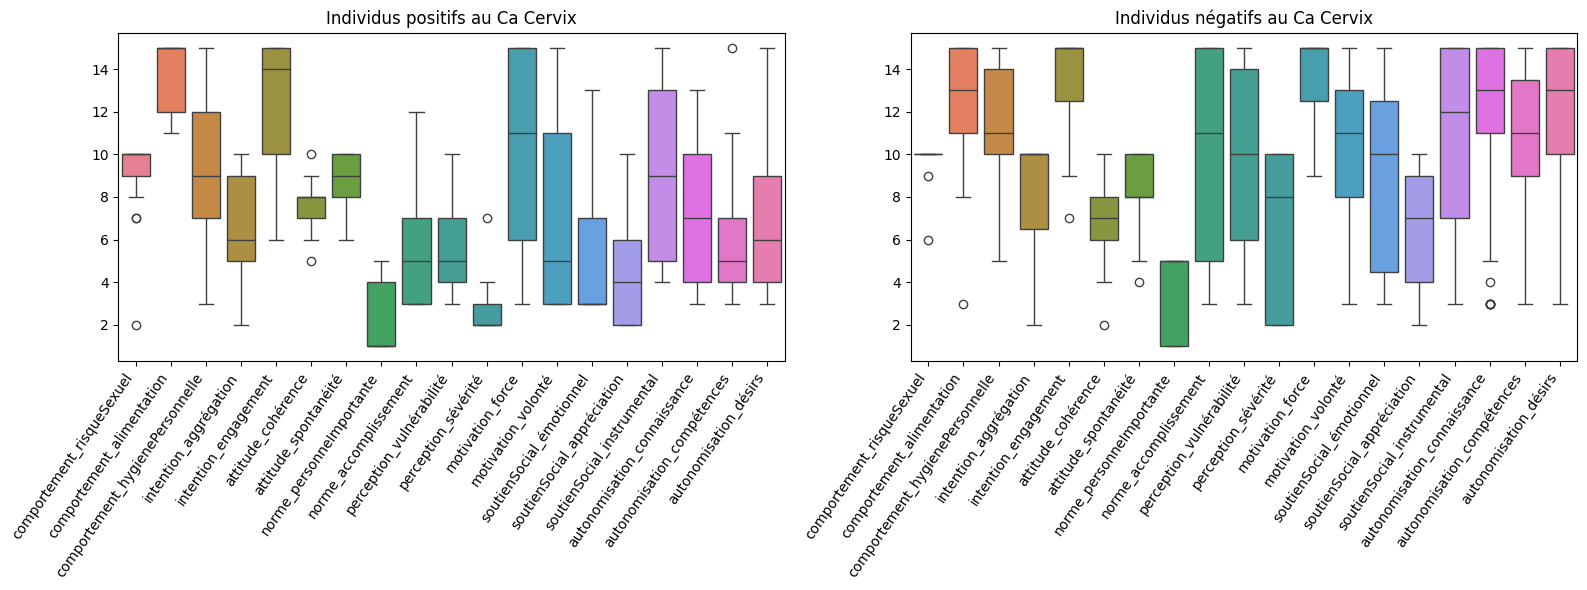

In [11]:
# Création d'une figure avec 2 sous-graphiques côte à côte
fig, axes = plt.subplots(1, 2, figsize=(16, 6))  # 1 ligne, 2 colonnes

# Boxplot pour les individus positifs
sns.boxplot(data=groupe_positif.iloc[:, :-1], ax=axes[0])  
axes[0].set_title("Individus positifs au Ca Cervix")

# Boxplot pour les individus négatifs
sns.boxplot(data=groupe_negatif.iloc[:, :-1], ax=axes[1])  
axes[1].set_title("Individus négatifs au Ca Cervix")

# Ajuster la rotation et l'alignement des étiquettes de l'axe X
for ax in axes:
    for label in ax.get_xticklabels():
        label.set_rotation(55)
        label.set_horizontalalignment('right')

plt.tight_layout()
plt.show()

Selon le boxplot des attributs entre les deux groupes (positif et négatif au Ca Cervix), les scores des comportements d'hygiène personnelle dans le groupe négatif ont tendance à être plus élevés que dans le groupe positif. Les personnes négatives au Ca Cervix obtiennent des scores plus élevés dans des déterminants tels que l'automatisation, le soutien social, la perception et la norme, comparativement à l'autre groupe. En général, les scores des comportements et de leurs déterminants dans le groupe négatif sont décalés vers la droite, ce qui indique des valeurs plus élevées.

##  K-fold Cross Validation

### On va diviser le jeu de données en k folds avec k = 4, incluant un ensemble d'entraînement et un ensemble de test. À chaque itération, on évalue l'ensemble de test et on prend la moyenne des résultats sur les 4 folds.

### Pour chaque fold (sous-ensemble), il y a $\frac{k-1}{k}$ % des individus dans l'ensemble d'entraînement et  $\frac{1}{k}$ % des individus dans l'ensemble de test.


In [12]:
kf = KFold(n_splits=4, shuffle=True, random_state=42)

for fold, (train_idx, test_idx) in enumerate(kf.split(df), 1):
    print(f"Fold {fold}:")
    print(f"  Train indices: {train_idx}")
    print(f"  Test indices: {test_idx}")
    print("-" * 30)

Fold 1:
  Train indices: [ 1  2  3  6  7  8 11 13 14 15 16 17 19 20 21 23 24 25 26 27 29 30 32 33
 35 36 37 38 39 40 41 42 43 44 46 48 51 52 53 55 57 58 59 60 61 63 64 65
 66 67 68 69 70 71]
  Test indices: [ 0  4  5  9 10 12 18 22 28 31 34 45 47 49 50 54 56 62]
------------------------------
Fold 2:
  Train indices: [ 0  1  2  3  4  5  6  8  9 10 11 12 14 15 17 18 20 21 22 23 24 26 27 28
 29 31 32 34 36 37 38 41 43 45 47 48 49 50 51 52 53 54 56 57 60 61 62 63
 64 65 66 67 68 70]
  Test indices: [ 7 13 16 19 25 30 33 35 39 40 42 44 46 55 58 59 69 71]
------------------------------
Fold 3:
  Train indices: [ 0  1  2  4  5  7  9 10 11 12 13 14 16 18 19 20 21 22 23 25 28 29 30 31
 32 33 34 35 37 39 40 42 43 44 45 46 47 49 50 51 52 54 55 56 58 59 60 62
 63 65 67 68 69 71]
  Test indices: [ 3  6  8 15 17 24 26 27 36 38 41 48 53 57 61 64 66 70]
------------------------------
Fold 4:
  Train indices: [ 0  3  4  5  6  7  8  9 10 12 13 15 16 17 18 19 22 24 25 26 27 28 30 31
 33 34 35 36 38 39 4

In [19]:
fold_indices = {f'fold_{fold}': {'train': train_idx, 'test': test_idx} 
                for fold, (train_idx, test_idx) in enumerate(kf.split(df), 1)}

In [31]:
print("La taille de training set pour chaque fold:",len(fold_indices["fold_1"]["train"]))  # Nombre d'indices dans le train set
print("La taille de test set pour chaque fold:",len(fold_indices["fold_1"]["test"]))   # Nombre d'indices dans le test set

La taille de training set pour chaque fold: 54
La taille de test set pour chaque fold: 18


In [32]:
np.savez('kfold_indices.npz', **fold_indices) #Sauvegarde les folds